In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

import numpy as np

In [2]:
# Charger le dataset

df = pd.read_csv('températures_globales.csv',sep=',')
df.head()

,Unnamed: 0,Year,Month,Anomaly-Gl,Uncertainty-Gl
0,0,1753,1,-1.264,3.651
1,1,1753,2,-1.985,4.124
2,2,1753,3,0.279,3.657
3,3,1753,4,-1.289,2.167
4,4,1753,5,-0.436,2.144


In [3]:
# on transforme notre dataset brute

df.tail()
df.isna().sum()
df.duplicated().sum()

df = df.drop(columns='Unnamed: 0')

df['Périodes'] = pd.to_datetime(df['Year'].astype(str)+'-'+ df['Month'].astype(str))            # periode annee/mois/jour
df = df.drop(columns=['Year','Month'])                                                          # on supprime colonnes annees et mois
df =df.reindex(columns=['Périodes','Anomaly-Gl','Uncertainty-Gl'])                              # pour confort visuel 

df = df.rename({'Anomaly-Gl':'Anomalies de T.°','Uncertainty-Gl':'Incertitude T.° anomalie'},axis=1)

df.head()

,Périodes,Anomalies de T.°,Incertitude T.° anomalie
0,1753-01-01,-1.264,3.651
1,1753-02-01,-1.985,4.124
2,1753-03-01,0.279,3.657
3,1753-04-01,-1.289,2.167
4,1753-05-01,-0.436,2.144


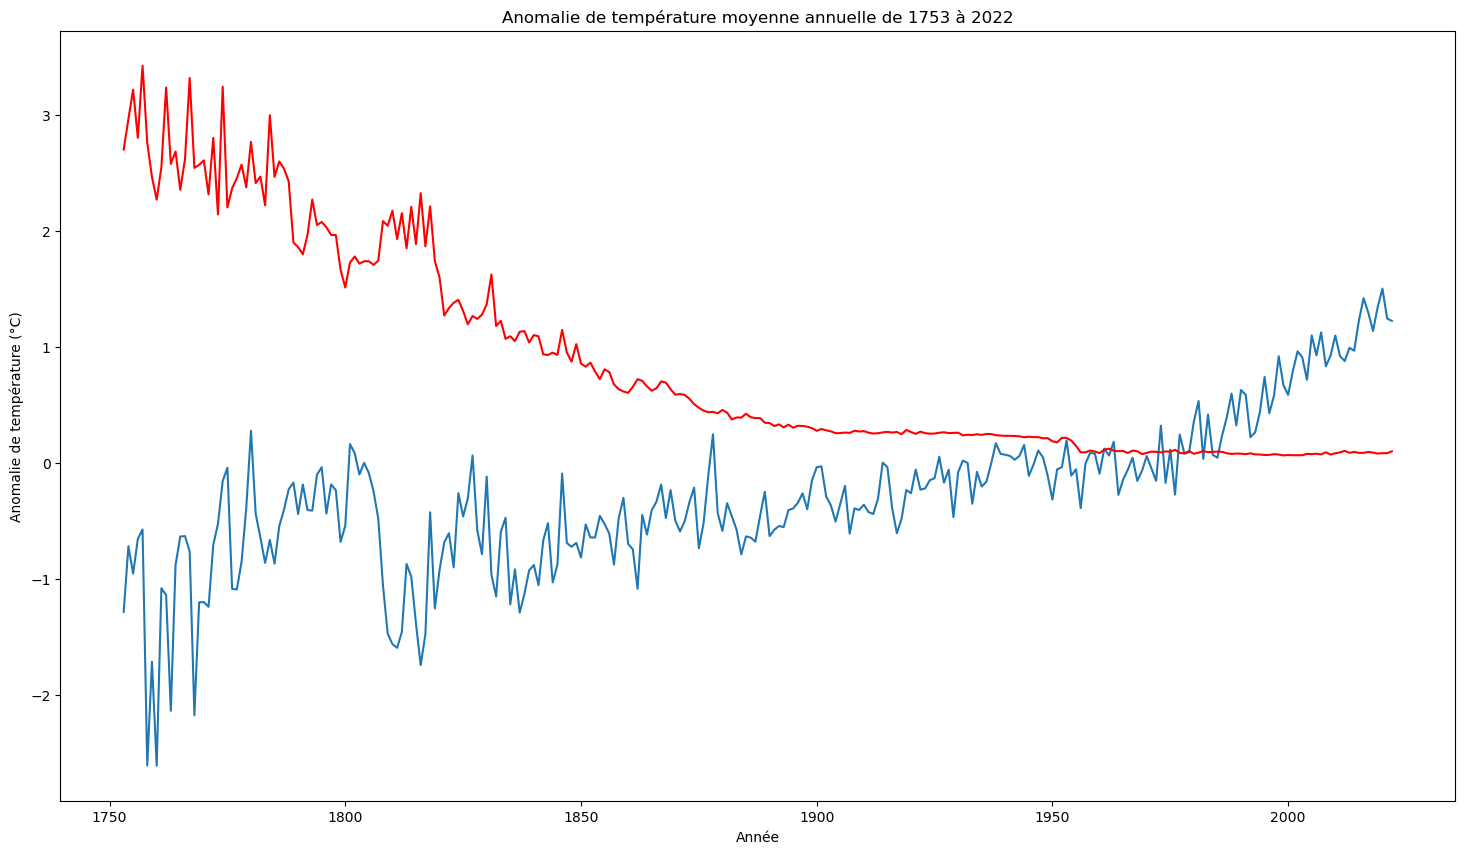

In [4]:
# Regrouper les données par année et calculer la moyenne de l'anomalie de température
df_annee_at = df.groupby(df['Périodes'].dt.year)['Anomalies de T.°'].mean()
df_annee_inc = df.groupby(df['Périodes'].dt.year)['Incertitude T.° anomalie'].mean()

# Tracer le graphique avec plt.plot()
plt.figure(figsize=(18,10))
plt.plot(df_annee_at.index, df_annee_at.values, label='moyenne annuelle anomalie de température')
plt.plot(df_annee_inc.index, df_annee_inc.values,color='red',label='incertitude des moyennes annuelles des anomalies de température')

# Ajouter les étiquettes d'axe et le titre
plt.xlabel('Année')
plt.ylabel('Anomalie de température (°C)')
plt.title('Anomalie de température moyenne annuelle de 1753 à 2022');

In [5]:
df = df.loc [ df['Périodes']>= '1960-01-01']     # choix de travailler à partir de cette période pour fiabilité des mesures

In [6]:
# Séparer les données d'entraînement et de test en fonction de la date cutoff

cutoff_date = pd.to_datetime("2012-01-01")              # ON TESTE SUR 2012 SOIT 15/100 DATA SET

train_df = df[df["Périodes"] < cutoff_date]
test_df = df[df["Périodes"] >= cutoff_date]

In [7]:
# Définir les variables d'entrée (années) et de sortie (anomalies de température) pour l'entraînement
X_train = train_df["Périodes"].values.reshape(-1, 1)
y_train = train_df["Anomalies de T.°"] .values.ravel()                        # reshape(-1, 1)

# Définir les variables d'entrée (années) et de sortie (anomalies de température) pour le test
X_test = test_df["Périodes"] .values.reshape(-1, 1)
y_test = test_df["Anomalies de T.°"] .values.ravel()   

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Définir les hyperparamètres à tester
params = {'max_depth': [1, 2, 3, 5, 7, 10, 12, 15, None],
          'n_estimators': [10, 50, 100, 200, 500],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]}
                                                                                                              # params = {'max_depth': [1,2, 3, 5, 7, 10, 12, 15],
                                                                                                                #'n_estimators' : [1,2,3,4,5,10,20,50,100,200,300,500,800,1000]}

# Créer un modèle de Random Forest Regression
rf = RandomForestRegressor()

# Utiliser la validation croisée TimeSeriesSplit pour mise en compte de l'aspect chronologie 
tscv = TimeSeriesSplit(n_splits=5)

# Utiliser la validation croisée pour trouver les meilleurs hyperparamètres de max_depth et n_estimators
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=tscv, scoring='neg_mean_squared_error',)
grid_search.fit(X_train, y_train)

# Obtenir la meilleure valeur de max_depth et de n_estimators et best_min_samples_split et best_min_samples_leaf

best_max_depth = grid_search.best_params_['max_depth']
best_n_estimators = grid_search.best_params_['n_estimators']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']


print(f"best_max_depth : {best_max_depth}")
print(f"best_n_estimators : {best_n_estimators}")
print(f"best_min_samples_split : {best_min_samples_split}")
print(f"best_min_samples_leaf : {best_min_samples_leaf}")

# Entraîner un modèle final avec la meilleure valeur de max_depth
rf_final = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,min_samples_split=best_min_samples_split,min_samples_leaf=best_min_samples_leaf)
rf_final.fit(X_train, y_train)

best_max_depth : 10
best_n_estimators : 10
best_min_samples_split : 2
best_min_samples_leaf : 4


RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=10)

In [9]:
# Faire des prédictions sur le jeu d'entraînement et le jeu de test
y_train_preds = rf_final.predict(X_train)
y_test_preds = rf_final.predict(X_test)

# Calculer les métriques de performance sur le jeu d'entraînement
train_mae = mean_absolute_error(y_train, y_train_preds)
train_mse = mean_squared_error(y_train, y_train_preds)
train_rmse = mean_squared_error(y_train, y_train_preds, squared=False)
train_r2 = r2_score(y_train, y_train_preds)

# Calculer les métriques de performance sur le jeu de test
test_mae = mean_absolute_error(y_test, y_test_preds)
test_mse = mean_squared_error(y_test, y_test_preds)
test_rmse = mean_squared_error(y_test, y_test_preds, squared=False)
test_r2 = r2_score(y_test, y_test_preds)

# Afficher les métriques de performance
print("Performances du modèle sur le jeu d'entraînement :")
print("MAE : ", train_mae)
print("MSE : ", train_mse)
print("RMSE : ", train_rmse)
print("R² : ", train_r2)

print('\n')
print("Performances du modèle sur le jeu de test :")
print("MAE : ", test_mae)
print("MSE : ", test_mse)
print("RMSE : ", test_rmse)
print("R² : ", test_r2)

Performances du modèle sur le jeu d'entraînement :
MAE :  0.17046149617965725
MSE :  0.0501145337045639
RMSE :  0.22386275640348016
R² :  0.7863199154717312


Performances du modèle sur le jeu de test :
MAE :  0.31197643660632296
MSE :  0.1650655470151337
RMSE :  0.4062825950187058
R² :  -0.42796529600888045


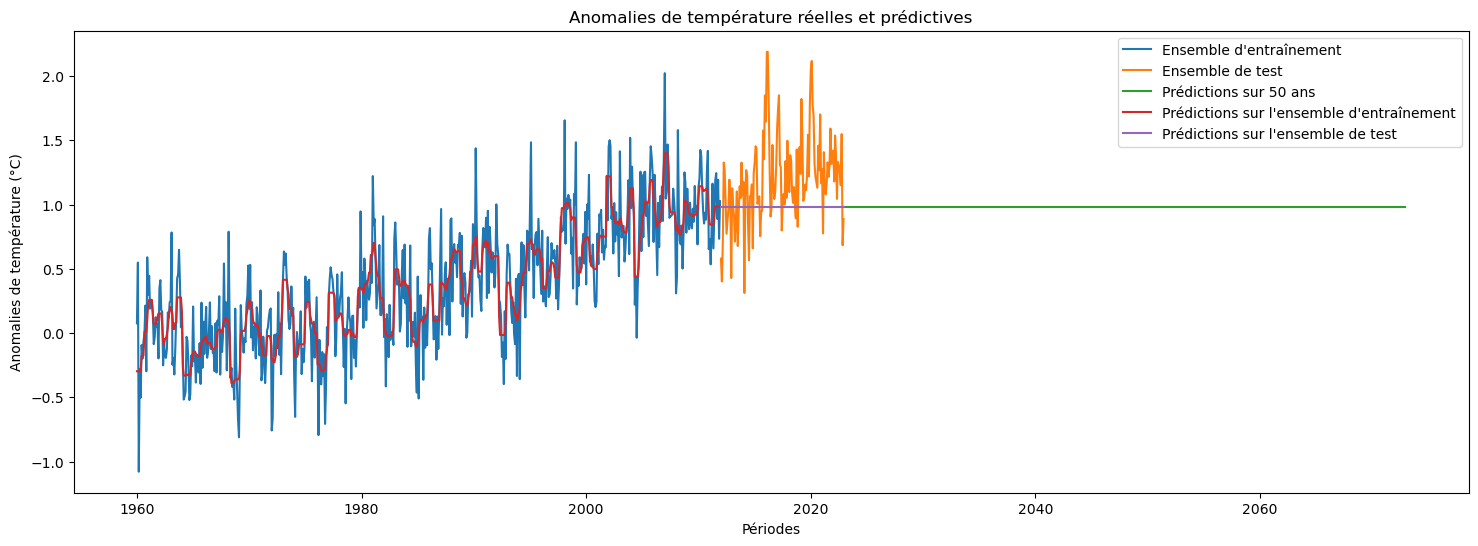

In [10]:
# Prédire les anomalies de température pour les 50 prochaines années
future_periods = pd.date_range(start='2022-12-01', end='2072-12-01', freq='MS')

future_periods = future_periods.to_numpy().reshape(-1,1)
future_predictions = rf_final.predict(future_periods)

# Créer un graphique des anomalies de température et des prédictions

plt.figure(figsize=(18, 6))
plt.plot(train_df["Périodes"], train_df["Anomalies de T.°"], label="Ensemble d'entraînement")
plt.plot(test_df["Périodes"], test_df["Anomalies de T.°"], label="Ensemble de test")


plt.plot(future_periods, future_predictions, label="Prédictions sur 50 ans")


plt.plot(train_df["Périodes"], y_train_preds, label="Prédictions sur l'ensemble d'entraînement")
plt.plot(test_df["Périodes"], y_test_preds, label="Prédictions sur l'ensemble de test")


plt.xlabel("Périodes")
plt.ylabel("Anomalies de température (°C)")
plt.title('Anomalies de température réelles et prédictives')
plt.legend()
plt.show();